In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.nn import CrossEntropyLoss, Conv2d, Sequential, BatchNorm2d
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torchinfo import summary

from ActiveShiftLayer import ASL
from util import test_loss, train_NN

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cpu


In [3]:
batch_size = 100

#transform images into normalized tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(
    "./data/MNIST",
    download=True,
    train=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    "./data/MNIST",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

In [7]:
A = Conv2d(8,8,5,padding = 'same')

print(summary(A, (100, 8, 28,28)))
print(summary(A, (100, 8, 14,14)))

Layer (type:depth-idx)                   Output Shape              Param #
Conv2d                                   [100, 8, 28, 28]          1,608
Total params: 1,608
Trainable params: 1,608
Non-trainable params: 0
Total mult-adds (M): 126.07
Input size (MB): 2.51
Forward/backward pass size (MB): 5.02
Params size (MB): 0.01
Estimated Total Size (MB): 7.53
Layer (type:depth-idx)                   Output Shape              Param #
Conv2d                                   [100, 8, 14, 14]          1,608
Total params: 1,608
Trainable params: 1,608
Non-trainable params: 0
Total mult-adds (M): 31.52
Input size (MB): 0.63
Forward/backward pass size (MB): 1.25
Params size (MB): 0.01
Estimated Total Size (MB): 1.89


In [4]:
from Models import LeNet

input_shape = (batch_size, 1, 28, 28)

LeNN = LeNet(input_shape, num_labels=10)

summary(LeNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 8, 28, 28]          208
│    └─BatchNorm2d: 2-2                  [100, 8, 28, 28]          16
│    └─Tanh: 2-3                         [100, 8, 28, 28]          --
│    └─AvgPool2d: 2-4                    [100, 8, 14, 14]          --
│    └─Conv2d: 2-5                       [100, 8, 14, 14]          1,608
│    └─BatchNorm2d: 2-6                  [100, 8, 14, 14]          16
│    └─Tanh: 2-7                         [100, 8, 14, 14]          --
│    └─AvgPool2d: 2-8                    [100, 8, 7, 7]            --
│    └─Flatten: 2-9                      [100, 392]                --
│    └─Linear: 2-10                      [100, 120]                47,160
│    └─Tanh: 2-11                        [100, 120]                --
│    └─

In [6]:
criterion = CrossEntropyLoss()
optimizer = optim.SGD(LeNN.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

In [7]:
leStats = train_NN(LeNN, train_dataloader,
        test_dataloader, epochs=6, optimizer=optimizer, criterion=criterion,
        scheduler=scheduler, device=device, steps_to_test=200, print_test=True)

[1,   200] train_loss: 0.363
test_loss: 0.108, test_accuracy: 96.67
[1,   400] train_loss: 0.098
test_loss: 0.079, test_accuracy: 97.42
[1,   600] train_loss: 0.086
test_loss: 0.055, test_accuracy: 98.25
[2,   200] train_loss: 0.050
test_loss: 0.041, test_accuracy: 98.79
[2,   400] train_loss: 0.043
test_loss: 0.041, test_accuracy: 98.66
[2,   600] train_loss: 0.044
test_loss: 0.047, test_accuracy: 98.57
[3,   200] train_loss: 0.030
test_loss: 0.031, test_accuracy: 99.02
[3,   400] train_loss: 0.027
test_loss: 0.030, test_accuracy: 99.11
[3,   600] train_loss: 0.030
test_loss: 0.032, test_accuracy: 98.89
[4,   200] train_loss: 0.022
test_loss: 0.029, test_accuracy: 99.04
[4,   400] train_loss: 0.022
test_loss: 0.030, test_accuracy: 99.05
[4,   600] train_loss: 0.023
test_loss: 0.028, test_accuracy: 99.08
[5,   200] train_loss: 0.018
test_loss: 0.028, test_accuracy: 99.13
[5,   400] train_loss: 0.020
test_loss: 0.028, test_accuracy: 99.08
[5,   600] train_loss: 0.020
test_loss: 0.028, t

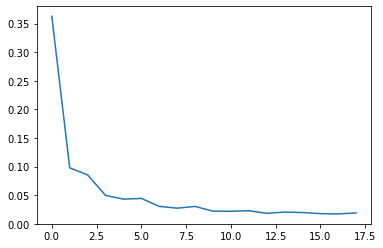

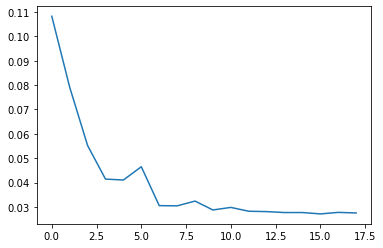

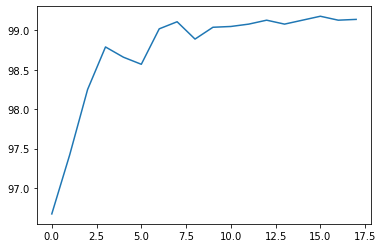

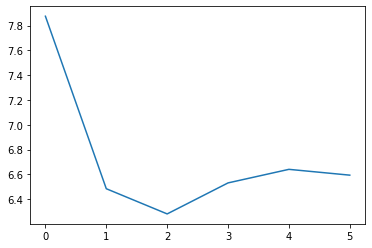

In [8]:
plt.plot(leStats[0])
plt.show()
plt.plot(leStats[1])
plt.show()
plt.plot(leStats[2])
plt.show()
plt.plot(leStats[3])
plt.show()

In [4]:
from Models import LeASLNet

input_shape = (batch_size, 1, 28, 28)

LeASLNN = LeASLNet(input_shape, 10, 1, device)

summary(LeASLNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
LeASLNet                                 [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 8, 28, 28]          16
│    └─CSC_block: 2-2                    [100, 8, 28, 28]          --
│    │    └─Sequential: 3-1              --                        176
│    └─Tanh: 2-3                         [100, 8, 28, 28]          --
│    └─AvgPool2d: 2-4                    [100, 8, 14, 14]          --
│    └─Tanh: 2-5                         [100, 8, 14, 14]          --
│    └─AvgPool2d: 2-6                    [100, 8, 7, 7]            --
│    └─Flatten: 2-7                      [100, 392]                --
│    └─Linear: 2-8                       [100, 120]                47,160
│    └─Tanh: 2-9                         [100, 120]                --
│    └─Linear: 2-10                      [100, 84]                 10,164
│    └

In [5]:
criterion = CrossEntropyLoss()
optimizer = optim.SGD(LeASLNN.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

In [6]:
leASLStats = train_NN(LeASLNN, train_dataloader,
        test_dataloader, epochs=6, optimizer=optimizer, criterion=criterion,
        scheduler=scheduler, device=device, steps_to_test=200, print_test=True)

[1,   200] train_loss: 0.429
test_loss: 0.124, test_accuracy: 96.17
[1,   400] train_loss: 0.117
test_loss: 0.079, test_accuracy: 97.64
[1,   600] train_loss: 0.093
test_loss: 0.076, test_accuracy: 97.62
[2,   200] train_loss: 0.062
test_loss: 0.053, test_accuracy: 98.26
[2,   400] train_loss: 0.052
test_loss: 0.049, test_accuracy: 98.43
[2,   600] train_loss: 0.045
test_loss: 0.047, test_accuracy: 98.51
[3,   200] train_loss: 0.032
test_loss: 0.036, test_accuracy: 98.88
[3,   400] train_loss: 0.034
test_loss: 0.037, test_accuracy: 98.77
[3,   600] train_loss: 0.036
test_loss: 0.034, test_accuracy: 98.86
[4,   200] train_loss: 0.027
test_loss: 0.033, test_accuracy: 98.94
[4,   400] train_loss: 0.026
test_loss: 0.034, test_accuracy: 98.94
[4,   600] train_loss: 0.026
test_loss: 0.032, test_accuracy: 99.0
[5,   200] train_loss: 0.023
test_loss: 0.031, test_accuracy: 98.99
[5,   400] train_loss: 0.023
test_loss: 0.031, test_accuracy: 98.96
[5,   600] train_loss: 0.023
test_loss: 0.031, te

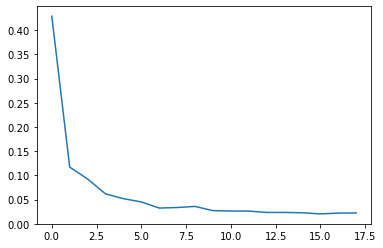

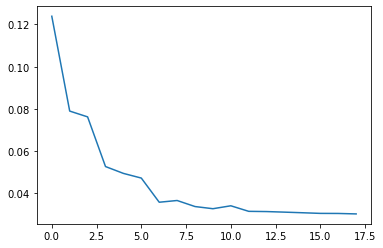

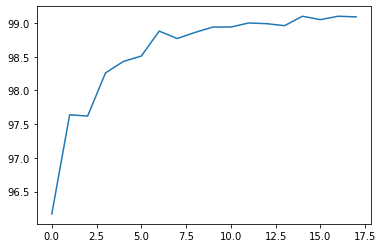

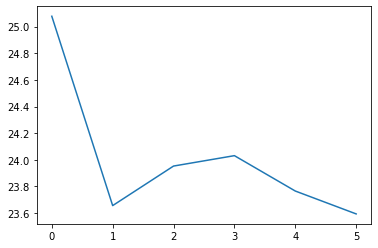

In [7]:
plt.plot(leASLStats[0])
plt.show()
plt.plot(leASLStats[1])
plt.show()
plt.plot(leASLStats[2])
plt.show()
plt.plot(leASLStats[3])
plt.show()

In [6]:
from Models import LeDepthNet

input_shape = (100, 1, 28, 28)

LeDepthNN = LeDepthNet(input_shape, 10, device)

summary(LeDepthNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
LeDepthNet                               [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 8, 28, 28]          16
│    └─Depth_wise_block: 2-2             [100, 8, 28, 28]          --
│    │    └─Sequential: 3-1              --                        240
│    └─Tanh: 2-3                         [100, 8, 28, 28]          --
│    └─AvgPool2d: 2-4                    [100, 8, 14, 14]          --
│    └─Depth_wise_block: 2-5             [100, 8, 14, 14]          --
│    │    └─Sequential: 3-2              --                        240
│    └─Tanh: 2-6                         [100, 8, 14, 14]          --
│    └─AvgPool2d: 2-7                    [100, 8, 7, 7]            --
│    └─Flatten: 2-8                      [100, 392]                --
│    └─Linear: 2-9                       [100, 120]                47,160
│    └─Ta

In [5]:
criterion = CrossEntropyLoss()
optimizer = optim.SGD(LeDepthNN.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

In [6]:
leDepthStats = train_NN(LeDepthNN, train_dataloader,
        test_dataloader, epochs=6, optimizer=optimizer, criterion=criterion,
        scheduler=scheduler, device=device, steps_to_test=200, print_test=True)

[1,   200] train_loss: 0.516
test_loss: 0.167, test_accuracy: 95.03
[1,   400] train_loss: 0.176
test_loss: 0.132, test_accuracy: 95.75
[1,   600] train_loss: 0.130
test_loss: 0.098, test_accuracy: 96.76
[2,   200] train_loss: 0.083
test_loss: 0.079, test_accuracy: 97.33
[2,   400] train_loss: 0.075
test_loss: 0.068, test_accuracy: 97.69
[2,   600] train_loss: 0.070
test_loss: 0.068, test_accuracy: 97.75
[3,   200] train_loss: 0.055
test_loss: 0.053, test_accuracy: 98.13
[3,   400] train_loss: 0.048
test_loss: 0.057, test_accuracy: 98.19
[3,   600] train_loss: 0.048
test_loss: 0.055, test_accuracy: 98.25
[4,   200] train_loss: 0.041
test_loss: 0.047, test_accuracy: 98.34
[4,   400] train_loss: 0.038
test_loss: 0.046, test_accuracy: 98.48
[4,   600] train_loss: 0.038
test_loss: 0.047, test_accuracy: 98.36
[5,   200] train_loss: 0.036
test_loss: 0.046, test_accuracy: 98.46
[5,   400] train_loss: 0.034
test_loss: 0.044, test_accuracy: 98.52
[5,   600] train_loss: 0.034
test_loss: 0.043, t

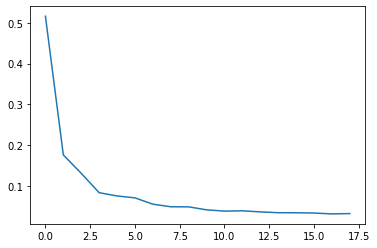

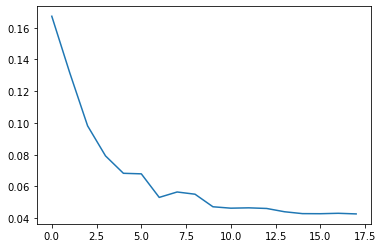

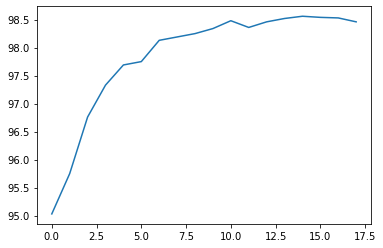

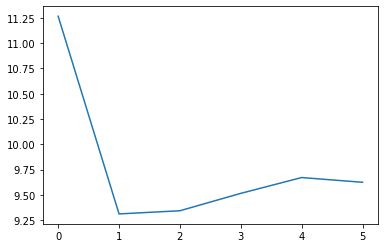

In [8]:
plt.plot(leDepthStats[0])
plt.show()
plt.plot(leDepthStats[1])
plt.show()
plt.plot(leDepthStats[2])
plt.show()
plt.plot(leDepthStats[3])
plt.show()